In [133]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error
import datetime
import json


from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import ColumnSummaryMetric, ColumnQuantileMetric, ColumnDriftMetric, DatasetDriftMetric, DataDriftTable, RegressionQualityMetric
from evidently.test_suite import TestSuite
from evidently.tests import TestNumberOfDriftedColumns
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset, DataDriftTestPreset
from evidently.ui.workspace import Workspace
from evidently.ui.workspace import WorkspaceBase, RemoteWorkspace


In [3]:
dataset = pd.read_csv(os.path.abspath(os.path.join(os.getcwd() + "\\..\\..\\data\\Housing.csv")))

# Printing first 5 records of the dataset
print(dataset.head(5))


      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  


In [6]:

s = (dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ', 
      len(object_cols))

Categorical variables:
['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
No. of. categorical features:  7


In [17]:
reference = dataset.sample(n=300, replace=False)
current = dataset.sample(n=300, replace=False)

In [7]:
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(dataset[object_cols]))
OH_cols.index = dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

In [8]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['price'], axis=1)
Y = df_final['price']

# Split the training set into 
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [9]:
model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred_train = model_SVR.predict(X_train)
Y_pred_test = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred_test))

0.2710074432862681


In [10]:
reference_with_pred = X_train.copy()
reference_with_pred["price"] = Y_train
reference_with_pred["prediction"] = Y_pred_train


current_with_pred = X_valid.copy()
current_with_pred["price"] = Y_valid
current_with_pred["prediction"] = Y_pred_test

<h2>Workspace & Project

In [37]:
ws = Workspace.create("getting started evidently")
project = ws.create_project("evidently project")
project.description = "getting started with evidently"

In [38]:
ws.list_projects()

[Project(id=UUID('0193f840-76ba-7095-8643-54ca54737d20'), name='evidently project', description='getting started with evidently', dashboard=DashboardConfig(name='evidently project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, org_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 12, 24, 16, 9, 54, 554475))]

In [30]:
project = ws.get_project('0193f840-76ba-7095-8643-54ca54737d20')
ws.add_project(project)

Project(id=UUID('0193c51c-ea06-75f8-b4f5-efee96587345'), name='evidently project', description=None, dashboard=DashboardConfig(name='evidently project', panels=[DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193e02f-a158-7544-91b6-94f5633c362a'), title='Share of Drifted Features', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text='Getting started sample - Evidently'), DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193e031-1893-7e34-a71e-f144badfe8ab'), title='Share of Drifted Features', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text='Getting started sample - Evidently')], tabs=[], tab_id_to_panel_ids={}), team_id=None, org_id=None, date_from=None, date_to=None, created_at=datetime.datetime(

<h2>Data drift report

In [103]:
report = Report(metrics=[DataDriftPreset()], timestamp=datetime.datetime.now(), tags=["drift1preset"])
report.run(reference_data=reference, current_data=current)
#report.show(mode='inline')
ws.add_report(project_id=project.id, report=report)

In [248]:
current_one = current[:1]
current_one
report = Report(metrics=[DataDriftPreset()], timestamp=datetime.datetime.now())
report.run(reference_data=reference, current_data=current_one, column_mapping=None)
ws.add_report(project_id=project.id, report=report)

In [98]:
dataset_drift_report = Report(metrics=[DatasetDriftMetric()], timestamp=datetime.datetime.now())
dataset_drift_report.run(reference_data=reference, current_data=current)
ws.add_report(project_id=project.id, report=dataset_drift_report)

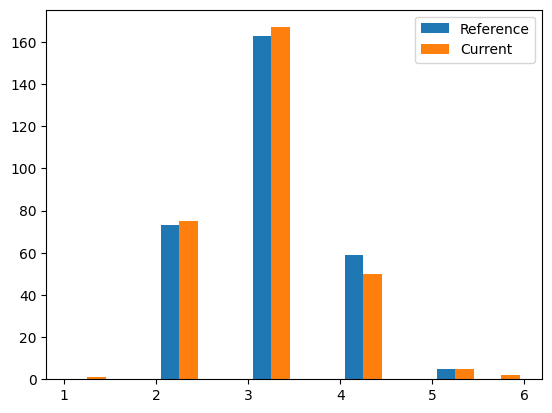

In [58]:
#Data drift table --> Data distrbution 
import matplotlib.pyplot as plt
plt.hist([reference["bedrooms"], current["bedrooms"]], label=["Reference", "Current"])
plt.legend(loc="upper right")

(1.0, 7.0)

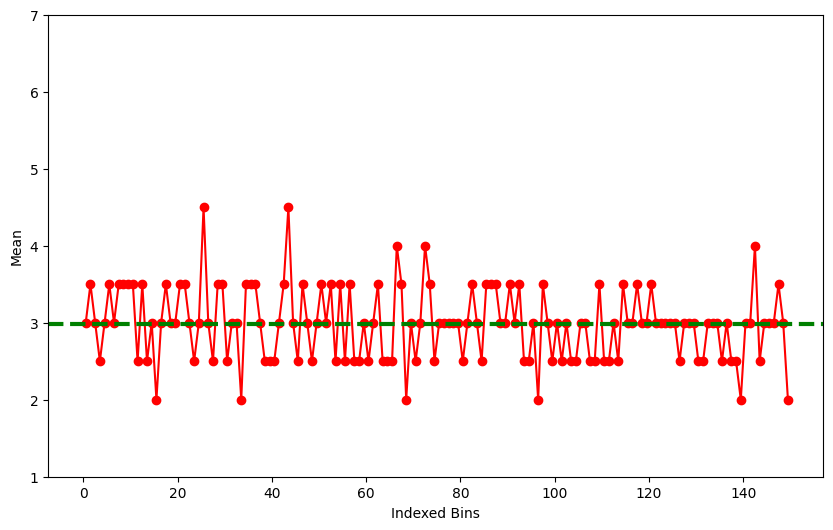

In [173]:
#Data drift
index = np.linspace(0, 150, len(reference))  # Index values
# Create bins
num_bins = 150
bins = np.linspace(index.min(), index.max(), num_bins + 1)  # Bin edges

# Digitize the index into bins
bin_indices = np.digitize(index, bins)
# Compute mean value in each bin
bin_means = [reference['bedrooms'][bin_indices == i].mean() if np.any(bin_indices == i) else np.nan for i in range(1, len(bins))]

bin_centers = (bins[:-1] + bins[1:]) / 2  # Calculate bin centers for plotting

plt.figure(figsize=(10, 6))
plt.plot(bin_centers, bin_means, marker='o', linestyle='-', color='r')
plt.plot(mean, linestyle='-', color='g')
plt.axhline(y=np.nanmean(reference["bedrooms"]), color = 'g',  linestyle = '--',   linewidth = 3)
plt.xlabel('Indexed Bins')
plt.ylabel('Mean')
#plt.title('Mean Value vs Indexed Bins')
#plt.grid()
plt.ylim(1, 7)

<h2>Data Quality

In [40]:
data_quality_report = Report(metrics=[
    DataQualityPreset(),
])

data_quality_report.run(reference_data=reference, current_data=current)
ws.add_report(project_id=project.id, report=data_quality_report)

In [117]:
pdd = data_quality_report.as_dict()
pdd

{'metrics': [{'metric': 'DatasetSummaryMetric',
   'result': {'almost_duplicated_threshold': 0.95,
    'current': {'target': None,
     'prediction': None,
     'date_column': None,
     'id_column': None,
     'number_of_columns': 13,
     'number_of_rows': 300,
     'number_of_missing_values': 0,
     'number_of_categorical_columns': 7,
     'number_of_numeric_columns': 6,
     'number_of_text_columns': 0,
     'number_of_datetime_columns': 0,
     'number_of_constant_columns': 0,
     'number_of_almost_constant_columns': 1,
     'number_of_duplicated_columns': 0,
     'number_of_almost_duplicated_columns': 0,
     'number_of_empty_rows': 0,
     'number_of_empty_columns': 0,
     'number_of_duplicated_rows': 0,
     'nans_by_columns': {'price': 0,
      'area': 0,
      'bedrooms': 0,
      'bathrooms': 0,
      'stories': 0,
      'mainroad': 0,
      'guestroom': 0,
      'basement': 0,
      'hotwaterheating': 0,
      'airconditioning': 0,
      'parking': 0,
      'prefarea': 0

In [19]:
from evidently.metrics import ColumnDriftMetric
from evidently.metrics import ColumnSummaryMetric
from evidently.metrics import DatasetMissingValuesMetric

data_qual_report = Report(metrics=[
    ColumnDriftMetric(column_name="price", stattest="wasserstein", stattest_threshold=0.03),
    ColumnSummaryMetric(column_name="price"),
    DatasetMissingValuesMetric()
])
data_qual_report.run(reference_data=reference, current_data=current)
ws.add_report(project_id=project.id, report=data_qual_report)
#data_qual_report.show(mode="inline")

<h2>Target Drift

In [42]:
column_mapping = ColumnMapping()
column_mapping.target = "price"
column_mapping.prediction = "prediction"
#column_mapping.numerical_features = report.get_column_mapping().numerical_features
#column_mapping.categorical_features = report.get_column_mapping().categorical_features

In [119]:
num_target_drift_report = Report(metrics=[
    TargetDriftPreset(),
])

num_target_drift_report.run(reference_data=reference_with_pred, current_data=current_with_pred, column_mapping=column_mapping)
ws.add_report(project_id=project.id, report=num_target_drift_report)

In [121]:
current_one = current_with_pred[:1]
num_target_drift_report.run(reference_data=reference_with_pred, current_data=current_one, column_mapping=column_mapping)
ws.add_report(project_id=project.id, report=num_target_drift_report)

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning:

divide by zero encountered in divide

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning:

invalid value encountered in multiply

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Pyth

<h2>Regression Drift

In [130]:


# Create a Report instance for regression with a set of predefined metrics
regression_performance_report = Report(metrics=[
    RegressionPreset(columns= ["price", "area"])
    # Preset is used for predefined set of regression metrics
])

# Run the report on the reference and current datasets
regression_performance_report.run(reference_data=reference_with_pred, current_data=current_with_pred, column_mapping=column_mapping)
ws.add_report(project_id=project.id, report=regression_performance_report)
# Display the report in 'inline' mode
#regression_performance_report.show(mode='inline')

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

C:\Users\EdwinVivekN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared e

<h2>Tests

In [27]:
#Data drift tests
data_drift_test_suite = TestSuite(tests=[
   DataDriftTestPreset(),
   TestNumberOfDriftedColumns()
])
 
data_drift_test_suite.run(reference_data=reference, current_data=current)
ws.add_test_suite(project_id=project.id, test_suite= data_drift_test_suite)

In [28]:
#Data stability tests
data_stability_test_suite = TestSuite(tests=[
   DataStabilityTestPreset()
])
 
data_stability_test_suite.run(reference_data=reference, current_data=current)
ws.add_test_suite(project_id=project.id, test_suite= data_stability_test_suite)
 

In [ ]:
#Data quality tests 

<h2> Save & Load Snapshots

In [445]:
# Export the report as JSON
report_json = regression_performance_report.json()
regression_performance_report.save_json("drift_report.json")

In [ ]:
# Load and accessing JSON data
with open('drift_report.json', 'r') as file:
    data = json.load(file)
data['metrics']

In [363]:
# Save the classification report to an HTML file
report.save_html("Data drift Report.html")

In [ ]:
# Export the classification report as a dictionary
report_dict = report.as_dict()

In [446]:
#Add snapshot to Project
from evidently.suite.base_suite import Snapshot
ws.add_snapshot(project.id, Snapshot.load("drift_report.json"))

ValidationError: 5 validation errors for ParsingModel[Snapshot]
__root__ -> id
  field required (type=value_error.missing)
__root__ -> metadata
  field required (type=value_error.missing)
__root__ -> tags
  field required (type=value_error.missing)
__root__ -> suite
  field required (type=value_error.missing)
__root__ -> options
  field required (type=value_error.missing)

<h2>Dashboards

In [47]:
from evidently.ui.dashboards import DashboardPanelCounter, ReportFilter, PanelValue, PlotType, CounterAgg, DashboardPanelPlot, DashboardPanelTestSuite, TestSuitePanelType
from evidently.renderers.html_widgets import WidgetSize

In [137]:
#Title Panel
project.dashboard.add_panel(
        DashboardPanelCounter(
            title="",
            filter=ReportFilter(metadata_values={}, tag_values=[]),
            value=None,
            text="Getting started sample - Evidently",
            agg=CounterAgg.NONE,
        )
)
project.save()

Project(id=UUID('0193f840-76ba-7095-8643-54ca54737d20'), name='evidently project', description='getting started with evidently', dashboard=DashboardConfig(name='evidently project', panels=[DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e6-e280-7cfd-8645-015c3f463783'), title='', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text='Getting started sample - Evidently')], tabs=[], tab_id_to_panel_ids={}), team_id=None, org_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 12, 24, 16, 9, 54, 554475))

In [138]:
#Counter panel - Dataset drift share
project.dashboard.add_panel(
        DashboardPanelCounter(
            title="Share of Drifted Features",
            filter=ReportFilter(metadata_values={}, tag_values=["drift1preset"]),
            value=PanelValue(
                metric_id="DatasetDriftMetric",
                field_path= DatasetDriftMetric.fields.share_of_drifted_columns, 
                legend="share",
            ),
            text="share",
            agg=CounterAgg.LAST,
            size=1,
        )
)
project.save()



Project(id=UUID('0193f840-76ba-7095-8643-54ca54737d20'), name='evidently project', description='getting started with evidently', dashboard=DashboardConfig(name='evidently project', panels=[DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e6-e280-7cfd-8645-015c3f463783'), title='', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text='Getting started sample - Evidently'), DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e7-07fa-73c6-a491-cc5eeb9911b3'), title='Share of Drifted Features', filter=ReportFilter(metadata_values={}, tag_values=['drift1preset'], include_test_suites=False), size=<WidgetSize.HALF: 1>, agg=<CounterAgg.LAST: 'last'>, value=PanelValue(field_path='share_of_drifted_columns', metric_id='DatasetDriftMetric', metric_fingerprint=None, metric_args={}, legend='share'), text='share')]

In [140]:
#Counter panel - Dataset drift count
project.dashboard.add_panel(
        DashboardPanelCounter(
            title="Number of Drifted Features",
            filter=ReportFilter(metadata_values={}, tag_values=["drift1preset"]),
            value=PanelValue(
                metric_id="DatasetDriftMetric",
                field_path= DatasetDriftMetric.fields.number_of_drifted_columns, 
                legend="Drifted Columns",
            ),
            text="Drifted Columns",
            agg=CounterAgg.SUM,
            size=1,
        )
)
project.save()

Project(id=UUID('0193f840-76ba-7095-8643-54ca54737d20'), name='evidently project', description='getting started with evidently', dashboard=DashboardConfig(name='evidently project', panels=[DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e6-e280-7cfd-8645-015c3f463783'), title='', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text='Getting started sample - Evidently'), DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e7-07fa-73c6-a491-cc5eeb9911b3'), title='Share of Drifted Features', filter=ReportFilter(metadata_values={}, tag_values=['drift1preset'], include_test_suites=False), size=<WidgetSize.HALF: 1>, agg=<CounterAgg.LAST: 'last'>, value=PanelValue(field_path='share_of_drifted_columns', metric_id='DatasetDriftMetric', metric_fingerprint=None, metric_args={}, legend='share'), text='share'),

In [143]:
#Target drift panel
project.dashboard.add_panel(
        DashboardPanelPlot(
            title="Target Drift - Price",
            filter=ReportFilter(metadata_values={}, tag_values=[]),
            values=[
                PanelValue(
                    metric_id="ColumnDriftMetric",
                    metric_args={"column_name.name": "price"},
                    field_path=ColumnDriftMetric.fields.drift_score,
                    legend="target: price",
                ),
            ],
            plot_type=PlotType.LINE,
            size=WidgetSize.HALF,
        )
    )
project.save()

Project(id=UUID('0193f840-76ba-7095-8643-54ca54737d20'), name='evidently project', description='getting started with evidently', dashboard=DashboardConfig(name='evidently project', panels=[DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e6-e280-7cfd-8645-015c3f463783'), title='', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text='Getting started sample - Evidently'), DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e7-07fa-73c6-a491-cc5eeb9911b3'), title='Share of Drifted Features', filter=ReportFilter(metadata_values={}, tag_values=['drift1preset'], include_test_suites=False), size=<WidgetSize.HALF: 1>, agg=<CounterAgg.LAST: 'last'>, value=PanelValue(field_path='share_of_drifted_columns', metric_id='DatasetDriftMetric', metric_fingerprint=None, metric_args={}, legend='share'), text='share'),

In [142]:
#Regression quality panel 
project.dashboard.add_panel(
   DashboardPanelPlot(
       title="Regression Metrics",
       filter=ReportFilter(metadata_values={}, tag_values=[]),
       values=[
       PanelValue(
           metric_id="RegressionQualityMetric",
           field_path=RegressionQualityMetric.fields.current.mean_abs_perc_error,
           legend="MAPE",
       ),
       PanelValue(
           metric_id="RegressionQualityMetric",
           field_path=RegressionQualityMetric.fields.current.rmse,
           legend="RMSE",
       ),
   ],
   plot_type=PlotType.LINE,
   size=WidgetSize.HALF,
   )
)
project.save()

Project(id=UUID('0193f840-76ba-7095-8643-54ca54737d20'), name='evidently project', description='getting started with evidently', dashboard=DashboardConfig(name='evidently project', panels=[DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e6-e280-7cfd-8645-015c3f463783'), title='', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text='Getting started sample - Evidently'), DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193f9e7-07fa-73c6-a491-cc5eeb9911b3'), title='Share of Drifted Features', filter=ReportFilter(metadata_values={}, tag_values=['drift1preset'], include_test_suites=False), size=<WidgetSize.HALF: 1>, agg=<CounterAgg.LAST: 'last'>, value=PanelValue(field_path='share_of_drifted_columns', metric_id='DatasetDriftMetric', metric_fingerprint=None, metric_args={}, legend='share'), text='share'),

In [ ]:

    # Adding test suites to the dashboard
project.dashboard.add_panel(
        DashboardPanelTestSuite(
            title="All tests: aggregated",
            filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=True),
            size=WidgetSize.HALF,
            time_agg="1M",
        )
    )

project.dashboard.add_panel(
        DashboardPanelTestSuite(
            title="All tests: detailed",
            filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=True),
            size=WidgetSize.HALF,
            panel_type=TestSuitePanelType.DETAILED,
            time_agg="1D",
        )
    )


In [393]:
#After you define the design of your monitoring panels, you must save the project.
project.save()

Project(id=UUID('0193c51c-ea06-75f8-b4f5-efee96587345'), name='evidently project', description=None, dashboard=DashboardConfig(name='evidently project', panels=[DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193c53a-832a-7cfe-952d-0415a7d2e8b9'), title='Share of Drifted Features', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, agg=<CounterAgg.LAST: 'last'>, value=PanelValue(field_path='share_of_drifted_columns', metric_id='DatasetDriftMetric', metric_fingerprint=None, metric_args={}, legend='share'), text='share'), DashboardPanelCounter(type='evidently:dashboard_panel:DashboardPanelCounter', id=UUID('0193db01-8c99-76f5-94bd-4aaae2e5da38'), title='Share of Drifted Features', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, agg=<CounterAgg.NONE: 'none'>, value=PanelValue(field_path='share_of_drifted_columns', metric_id='Datas

In [136]:
#Delete panels
project.dashboard.panels = []
project.save()

Project(id=UUID('0193f840-76ba-7095-8643-54ca54737d20'), name='evidently project', description='getting started with evidently', dashboard=DashboardConfig(name='evidently project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, org_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 12, 24, 16, 9, 54, 554475))